***Data Pre-Processor***


In [1]:
%run DeepFake_Dataloader.py
%run utils.py

In [2]:
import h5py
import torch
import numpy as np

# Pretty Print
import pprint
pp = pprint.PrettyPrinter(width=20)

In [13]:
# batch_sz = 128 
batch_sz = 10
image_folder_path='/home/jupyter/image_folder_BCCC_256'

dataloader = get_preprocessors(
    image_root=image_folder_path, 
    batch_size=batch_sz,
    output_size=182,
    batch_size=32,
    num_workers=8,
    destf_hdf5='/content/LSUN_BCCC_256.hdf5',
    transforms=convert_to_256
)

total_imgs  = len(dataloader.dataset.samples)
data_origin = dataloader.dataset.class_to_idx
data_origin.update({y:x for x,y in data_origin.items()})
print(dataloader.dataset)
print('Classes:')
pp.pprint(dataloader.dataset.classes)

/home/jupyter/image_folder_BCCC_256
Dataset DeepFakePreProcessor
    Number of datapoints: 80003
    Root location: /home/jupyter/image_folder_BCCC_256
Classes:
['lsun_bedrooms',
 'lsun_cars',
 'lsun_cats',
 'lsun_churches',
 'stylegan1_bedrooms',
 'stylegan2_cars',
 'stylegan2_cats',
 'stylegan2_churches']


In [14]:
progress = ProgressMonitor(length=total_imgs)
rad_len  = 182
hdf5_fn  = 'LSUN_BCCC_256.hdf5'
with h5py.File(hdf5_fn, 'w') as f:
    """
        Create HDF5 datasets 
    """
    data_dset = f.create_dataset('fft_data',  (total_imgs, rad_len), dtype='f')
    lbl_dset  = f.create_dataset('lbl_data',  (total_imgs,),     dtype='i')
    orgn_dset = f.create_dataset('orgn_data', (total_imgs,),     dtype='i')
    img_size  = f.create_dataset('img_size',  (total_imgs,),     dtype='i')
    data_size = f.create_dataset('data_size', (total_imgs,),     dtype='i')
    
    for i, (img_data, target, origin_dataset, _, _) in enumerate(dataloader):
        start_idx = i * batch_sz
        for j in range(img_data.shape[0]):
            idx = start_idx + j
            progress.update(1, 0)
            if (target[j] > 1):
                print(target[j])
            data_dset[idx] = img_data[j]
            lbl_dset[idx]  = target[j]
            orgn_dset[idx] = data_origin[origin_dataset[j]]
            img_size[idx]  = data_img_size[origin_dataset[j]]
            data_size[idx] = rad_size[origin_dataset[j]]
        

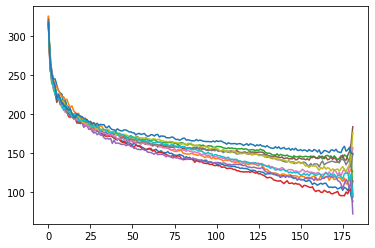

In [15]:
import matplotlib.pyplot as plt

with h5py.File(hdf5_fn, 'r') as f:
    dset = f['fft_data']
    plt.plot(dset[200])
    for i in range(10):
        plt.plot(dset[np.random.randint(20000)])
#         plt.show()
    plt.show()

In [17]:
with h5py.File(hdf5_fn, 'r') as f:
    dset = f['lbl_data']
    for i in range(len(dset)):
        if dset[i] != 1 and dset[i] != 0:
            print(dset[i])

In [18]:
!gcloud auth activate-service-account --key-file ./playground-270702-4d2df0765336.json

Activated service account credentials for: [1091534425226-compute@developer.gserviceaccount.com]


In [19]:
# auth.authenticate_user()

project_id = 'playground-270702'
!gcloud config set project {project_id}
!gsutil ls

bucket_name = 'img-hosting-bucket'
!gsutil -m cp -r /home/jupyter/CSE253_FinalProject/LSUN_BCCC_256.hdf5 gs://{bucket_name}/

Updated property [core/project].
gs://img-hosting-bucket/
Copying file:///home/jupyter/CSE253_FinalProject/LSUN_BCCC_256.hdf5 [Content-Type=application/octet-stream]...
- [1/1 files][ 56.8 MiB/ 56.8 MiB] 100% Done                                    
Operation completed over 1 objects/56.8 MiB.                                     


In [20]:
!wget https://storage.googleapis.com/img-hosting-bucket/LSUN_BCCC_256.hdf5

--2020-03-16 08:16:52--  https://storage.googleapis.com/img-hosting-bucket/LSUN_BCCC_256.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c0a::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59524720 (57M) [application/octet-stream]
Saving to: ‘LSUN_BCCC_256.hdf5.1’

LSUN_BCCC_256.hdf5. 100%[===================>]  56.77M   125MB/s    in 0.5s    

2020-03-16 08:16:53 (125 MB/s) - ‘LSUN_BCCC_256.hdf5.1’ saved [59524720/59524720]



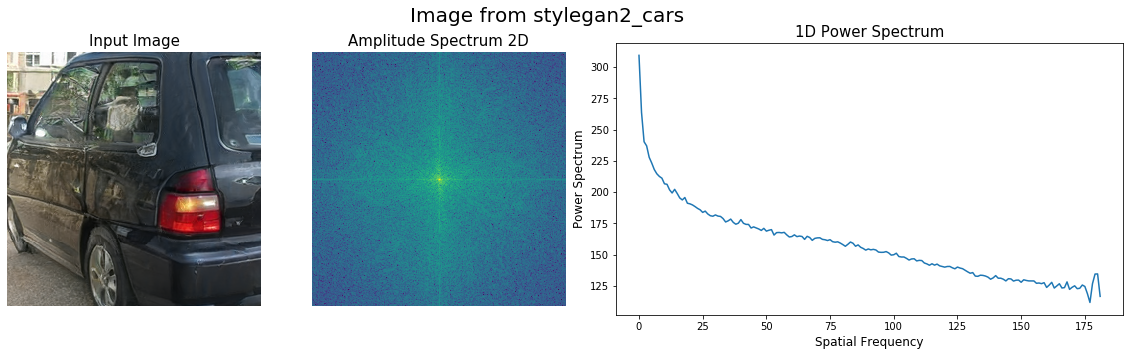

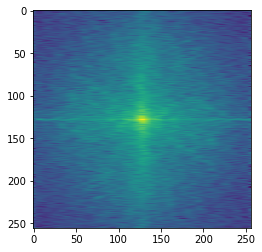

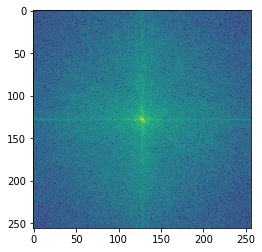

In [21]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from PIL import Image
import random
from torchvision import transforms
import numpy as np
import scipy.signal as signal

b, a = signal.butter(8, 0.125)


file_name = './imgs/class_1'

(img_data, target, origin_dataset, img, ms_img) = next(iter(dataloader))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col',
                        gridspec_kw={'hspace': 1, 'wspace': 0.15, 'width_ratios': [1, 1, 2]},
                        figsize=(20, 5))
fig.suptitle('Image from ' + origin_dataset[0], fontsize=20)

ax1.axis('off')
ax2.axis('off')

ax1.set_title('Input Image',           size=15)
ax2.set_title('Amplitude Spectrum 2D', size=15)
ax3.set_title('1D Power Spectrum',     size=15)

ax1.imshow(img[0])
ax2.imshow(ms_img[0])

plt.xlabel('Spatial Frequency', fontsize=12)
plt.ylabel('Power Spectrum',    fontsize=12)
ax3.plot(img_data[0])

plt.savefig(file_name + '.jpg', dpi=300)
plt.show()

y = signal.filtfilt(b, a, ms_img[0], padlen=150)

plt.imshow(y)
plt.figure()
plt.imshow(ms_img[0])